# Clustering Analysis of Taxi Trip Records
The overarching objective of this notebook is to conduct a clustering analysis of taxi trip records to identify distinct groups or clusters of taxi users. Through the application of clustering techniques, including KMeans and the Gaussian Mixture Model (GMM), the analysis aims to unveil underlying patterns and behaviors that typify different segments of taxi users. Such insights hold significant value for urban planning, targeted marketing strategies, and transportation optimization within the cityscape.

## Importing Necessary Libraries
We start by importing necessary libraries, each serving a specific purpose in our data preparation process:

- `numpy` and `pandas`: These libraries are essential for handling and manipulating our data.
- `datetime`: This library is used for handling date and time data, which are crucial features in our dataset.
- `geopandas`: This library allows us to work with geographic data, which is significant given the spatial nature of our taxi trips data.
- `seaborn` and `matplotlib.pyplot`: These libraries are used for data visualization, helping us understand the distribution and relationships of our data.
- `gc`: This library provides a garbage collection module for managing memory usage.
- `pickle`: We use this library for loading and saving data in pickle format, a common format for serializing and deserializing Python object structures.





In [1]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

import gc
import pickle

from IPython.display import display, clear_output
import time

from google.colab import drive
from google.colab import data_table
data_table.enable_dataframe_formatter()

import warnings
warnings.filterwarnings('ignore')

## Data Loading Process

In this section, Google Drive is mounted to enable data loading. This step is integral when working in the Google Colab environment, as it grants access to files stored within Google Drive. A pickle file, a standard Python-native data storage format, is read into a pandas DataFrame. This file contains the preprocessed taxi trip records that will be the foundation of our clustering analysis.



In [2]:
drive.mount('/content/drive')
pickle_file_path = '/content/drive/MyDrive/3A23/Data/trips_2013_extended.pkl'

# Load the Pickle file into a Pandas DataFrame
with open(pickle_file_path, 'rb') as file:
    df_trips = pickle.load(file)

Mounted at /content/drive


## Data Overview

The subsequent cell provides an initial overview of the DataFrame, showcasing column names, non-null counts, and data types. This preliminary inspection aids in understanding the data's structure and informs subsequent analytical steps.

In [3]:

df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8390871 entries, 0 to 8449591
Data columns (total 29 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   start_time                 datetime64[ns]
 1   end_time                   datetime64[ns]
 2   duration                   float64       
 3   distance                   float64       
 4   start_census_tract         int64         
 5   end_census_tract           int64         
 6   fare                       float64       
 7   extras                     float64       
 8   tips                       float64       
 9   tolls                      float64       
 10  trip_total                 float64       
 11  min_distance_to_poi_start  float64       
 12  min_distance_to_poi_end    float64       
 13  poi_count_start            float64       
 14  poi_count_end              float64       
 15  airport_trip               int64         
 16  is_special_date            int64    

In [4]:
df_trips.head()

,start_time,end_time,duration,distance,start_census_tract,end_census_tract,fare,extras,tips,tolls,...,is_weekend,part_of_day,cost_per_minute,cost_per_km,part_of_day_Afternoon,part_of_day_Early Morning,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,payment_type_encoded
0,2013-01-01,2013-01-01 00:15:00,480.0,8.851392,17031081403,17031031501,13.25,0.0,0.0,0.0,...,0,Early Morning,0.027604,1.496940,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-01,2013-01-01 00:15:00,780.0,40.233600,17031081000,17031070200,9.65,2.0,0.0,0.0,...,0,Early Morning,0.012372,0.239849,0.0,1.0,0.0,0.0,0.0,0
2,2013-01-01,2013-01-01 00:15:00,480.0,37.014912,17031062200,17031830700,8.05,2.0,0.0,0.0,...,0,Early Morning,0.016771,0.217480,0.0,1.0,0.0,0.0,0.0,0
3,2013-01-01,2013-01-01 00:15:00,600.0,7.081114,17031062100,17031081500,11.45,2.0,0.0,0.0,...,0,Early Morning,0.019083,1.616977,0.0,1.0,0.0,0.0,0.0,0
4,2013-01-01,2013-01-01 00:15:00,720.0,1.287475,17031081800,17031081600,7.65,3.0,0.0,0.0,...,0,Early Morning,0.010625,5.941862,0.0,1.0,0.0,0.0,0.0,0


## Feature Standardization

In this cell, we standardize the numerical features in the DataFrame so they all have a mean of 0 and standard deviation of 1. This is an important step before running KMeans, as the algorithm is sensitive to the scale of the features. Due to limited RAM, we perform this operation in batches.

In [5]:
from sklearn.preprocessing import StandardScaler


# List of features to use for clustering
features = ['duration', 'distance', 'fare', 'extras', 'tips', 'tolls', 'trip_total', 'is_weekend', 'cost_per_minute',
            'cost_per_km', 'part_of_day_Afternoon','part_of_day_Early Morning',
            'part_of_day_Evening', 'part_of_day_Morning','part_of_day_Night','min_distance_to_poi_start',
            'min_distance_to_poi_end', 'poi_count_start', 'poi_count_end', 'airport_trip'] #'is_special_date' (not significant)

# Specify the batch size
batch_size = 100000

# Initialize an empty array to store the scaled data
scaled_data = np.empty((0, len(features)))

# Standardize the features in batches
scaler = StandardScaler()
for i in range(0, len(df_trips), batch_size):
    batch = df_trips.iloc[i:i+batch_size]
    scaled_batch = scaler.fit_transform(batch[features])
    scaled_data = np.vstack((scaled_data, scaled_batch))

del scaled_batch
gc.collect()


0

## Initial Clustering Considerations

The clustering process commences with an initial guess of 5 clusters, a heuristic decision to kickstart the analysis. The inertia value, representing the sum of squared distances to the nearest cluster center, is examined at this stage. A lower inertia signifies closer proximity of data points to their respective cluster centers, indicative of a potentially better clustering. However, this initial attempt is exploratory, and the optimal number of clusters will be rigorously determined through the elbow method in the following sections.


In [6]:
# KMeans Clustering with inital guess of k = 5
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(scaled_data)
df_trips['kmeans_cluster'] = kmeans.labels_
print(kmeans.inertia_)

del kmeans
gc.collect()

87069618.47947109


0

In [7]:
df_trips.groupby('kmeans_cluster').size()

kmeans_cluster
0     850842
1    2462065
2    1137386
3    1004248
4    1317735
5    1618595
dtype: int64

In [8]:
df_trips[features+['kmeans_cluster']].groupby('kmeans_cluster').mean().round(2)

,duration,distance,fare,extras,tips,tolls,trip_total,is_weekend,cost_per_minute,cost_per_km,part_of_day_Afternoon,part_of_day_Early Morning,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,min_distance_to_poi_start,min_distance_to_poi_end,poi_count_start,poi_count_end,airport_trip
kmeans_cluster,,,,,,,,,,,,,,,,,,,,
0,1945.47,19.70,34.12,2.30,3.86,0.0,40.27,0.23,0.02,7.60,0.36,0.03,0.27,0.23,0.1,0.26,0.25,7.96,7.37,0.98
1,612.65,2.98,8.30,0.53,0.51,0.0,9.33,0.27,0.02,9.84,0.00,0.00,1.00,0.00,0.0,0.17,0.20,11.12,8.19,0.00
2,542.14,2.68,7.88,0.21,0.52,0.0,8.62,0.13,0.02,9.58,0.00,0.00,0.00,1.00,0.0,0.17,0.15,10.14,14.10,0.00
3,544.73,3.24,8.75,0.78,0.62,0.0,10.15,0.78,0.02,11.19,0.00,1.00,0.00,0.00,0.0,0.22,0.25,5.29,5.13,0.00
4,557.10,3.23,8.54,0.71,0.56,0.0,9.81,0.34,0.02,10.13,0.00,0.00,0.00,0.00,1.0,0.19,0.22,8.13,6.50,0.00
5,533.49,2.59,7.69,0.44,0.45,0.0,8.58,0.27,0.02,9.89,1.00,0.00,0.00,0.00,0.0,0.15,0.16,12.30,11.62,0.00


## Optimal Cluster Determination (K-Means)

The determination of the optimal number of clusters is a paramount aspect of clustering analysis. Utilizing the elbow method, a visual and intuitive technique, the point where additional clusters cease to yield significant inertia improvement is identified. This 'elbow' represents a point of diminishing returns, where further cluster addition neither significantly reduces inertia nor enhances interpretation. This optimization avoids both over-clustering and under-clustering, leading to a more insightful and accurate clustering outcome.




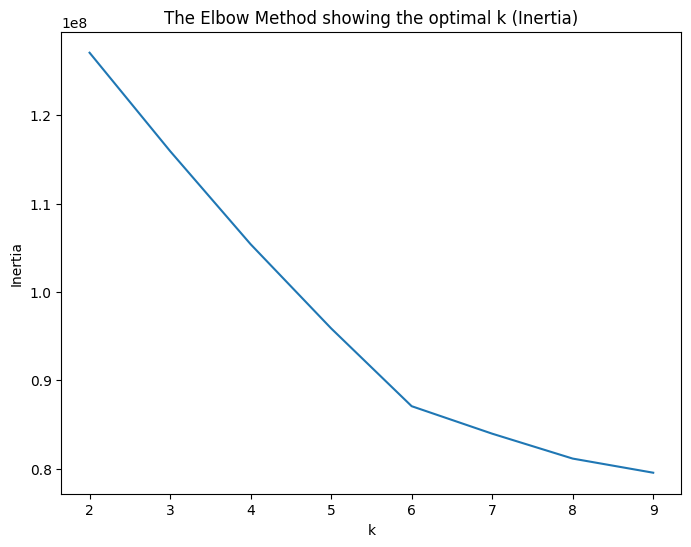

3368

In [9]:
# Finding the right k
# Placeholder for the metrics
inertias = []

# Range of k values to try
k_values = range(2, 10)

for k in k_values:

    display(f'Calculating for k={k}') # Progress tracker
    clear_output(wait=True)

    # Create a new KMeans instance for each k
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # Append the inertia
    inertias.append(kmeans.inertia_)

# Plot Inertia
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k (Inertia)')
plt.show()

del kmeans
gc.collect()

Using the elbow-Method we chose 6 clusters to be the optimal number of clusters.

In [20]:
# KMeans Clustering with optimal k = 6
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42).fit(scaled_data)
df_trips['kmeans_cluster'] = kmeans.labels_
print(kmeans.inertia_)

del kmeans
gc.collect()

87069618.47947109


0

In [21]:
df_trips.groupby('kmeans_cluster').size()

kmeans_cluster
0     850842
1    2462065
2    1137386
3    1004248
4    1317735
5    1618595
dtype: int64

## In-Depth Analysis of Identified Clusters
The clustering analysis was systematically approached by assessing the mean of each feature for every identified cluster. By categorizing the data according to the 'kmeans_cluster' labels and computing the mean for each feature, unique characteristics that define and differentiate the clusters were elucidated. This analytical process facilitated the recognition of distinct patterns and behaviors within the dataset, revealing the underlying dynamics of each cluster.

1. **Airport Commuters (Cluster 0):** This cluster is characterized by long durations and distances, and significantly involves airport trips. The absence of significant differences in the part of the day or the weekend feature indicates that these are likely Airport Commuters. They might include business travelers or residents flying in and out, since the trips happen throughout the entire week without clear time patterns. This pattern is indicative of routine long-distance travel, likely connecting the city center to distant airports.

2. **Evening Urbanites (Cluster 1):** Characterized by evening travel and enriched with points of interest at both start and end locations, this cluster suggests an affinity for evening urban activities. The relatively balanced pattern across weekdays and weekends, coupled with the spatial features, supports the hypothesis that this group might include residents or visitors engaged in cultural, social, or culinary pursuits, reflecting a thriving urban evening culture.

3. **Morning Commuters (Cluster 2):** This cluster is identified by morning travel with a below-average weekend feature. Likely representing workers commuting to workplaces during weekdays and early travelers initiating their daily activities, this group portrays the typical pattern of work-related travel or early-bird tourism.

4. **Partygoers and Weekend Early Birds (Cluster 3):** This cluster likely includes social travelers returning from late-night weekend activities such as clubs, as well as weekend workers commuting early. With the weekend feature well above average, this group may represent a blend of weekend leisure and work-related activities, reflecting the dynamics of the city's nightlife and early weekend working shifts.

5. **Night Owls and Late Leisure Seekers (Cluster 4):** This cluster may represent individuals such as shift workers returning from late-night work or patrons traveling from late-night entertainment venues. A slightly above-average weekend feature could point to an inclination towards late-night activities such as bar-hopping or clubbing, particularly during the weekends. This blend of work and leisure portrays a city that thrives well into the night.

6. **Daytime City Explorers (Cluster 5):** Representing trips mainly in the afternoon, this group could consist of tourists exploring urban attractions or locals running daily errands. With above-average numbers of points of interest and a distinct afternoon feature, this cluster likely mirrors a pattern of daytime exploration or errands within the city, showcasing the hustle and bustle of daily city life.




In [22]:
df_trips[features+['kmeans_cluster']].groupby('kmeans_cluster').mean().round(2)

,duration,distance,fare,extras,tips,tolls,trip_total,is_weekend,cost_per_minute,cost_per_km,part_of_day_Afternoon,part_of_day_Early Morning,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,min_distance_to_poi_start,min_distance_to_poi_end,poi_count_start,poi_count_end,airport_trip
kmeans_cluster,,,,,,,,,,,,,,,,,,,,
0,1945.47,19.70,34.12,2.30,3.86,0.0,40.27,0.23,0.02,7.60,0.36,0.03,0.27,0.23,0.1,0.26,0.25,7.96,7.37,0.98
1,612.65,2.98,8.30,0.53,0.51,0.0,9.33,0.27,0.02,9.84,0.00,0.00,1.00,0.00,0.0,0.17,0.20,11.12,8.19,0.00
2,542.14,2.68,7.88,0.21,0.52,0.0,8.62,0.13,0.02,9.58,0.00,0.00,0.00,1.00,0.0,0.17,0.15,10.14,14.10,0.00
3,544.73,3.24,8.75,0.78,0.62,0.0,10.15,0.78,0.02,11.19,0.00,1.00,0.00,0.00,0.0,0.22,0.25,5.29,5.13,0.00
4,557.10,3.23,8.54,0.71,0.56,0.0,9.81,0.34,0.02,10.13,0.00,0.00,0.00,0.00,1.0,0.19,0.22,8.13,6.50,0.00
5,533.49,2.59,7.69,0.44,0.45,0.0,8.58,0.27,0.02,9.89,1.00,0.00,0.00,0.00,0.0,0.15,0.16,12.30,11.62,0.00


## Gaussian Mixture Model Introduction and Optimal Component Determination

The Gaussian Mixture Model (GMM) is a versatile clustering technique that models the data as a combination of multiple Gaussian distributions. Determining the optimal number of components (Gaussian distributions) is vital for the model's performance and interpretability.

The elbow method is employed for this purpose, analogous to its application in KMeans clustering. By fitting the GMM with varying numbers of components and evaluating the corresponding Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC), a plot is generated to visualize the model's performance.

The 'elbow' in this plot represents the point where adding more components results in diminishing returns in terms of model fit improvement. Beyond this point, additional complexity may lead to overfitting without substantially enhancing the model's explanatory power.

Selecting the optimal number of components through this method ensures that the GMM is neither overly complex nor overly simplistic. It balances fit and parsimony, leading to a model that accurately captures the underlying structure of the data without unnecessary complexity. This rigorous approach to component selection contributes to the robustness and validity of the GMM clustering analysis, providing insights that are both meaningful and generalizable.


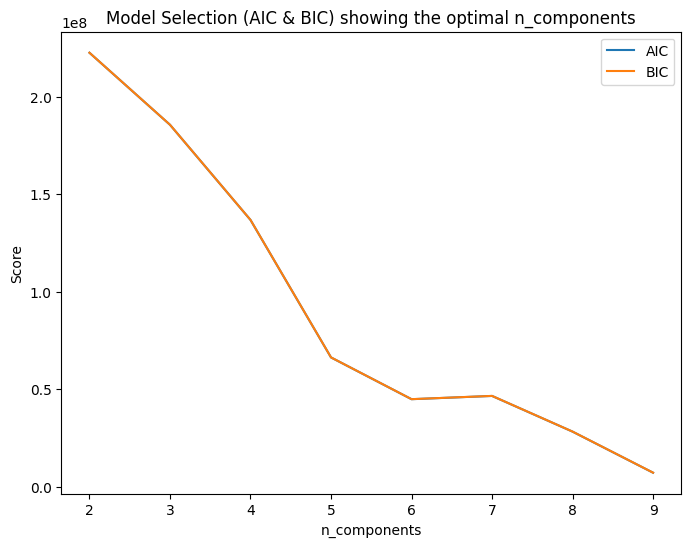

3849

In [15]:
from sklearn.mixture import GaussianMixture

# Placeholder for the AIC and BIC
aics = []
bics = []

# Range of n_components to try
n_components = range(2, 10)

for n in n_components:

    display(f'Calculating for n={n}') # Progress tracker
    clear_output(wait=True)

    # Create a new GMM instance for each n
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_data)

    # Append the AIC and BIC to our lists
    aics.append(gmm.aic(scaled_data))
    bics.append(gmm.bic(scaled_data))

# Plot AIC and BIC
plt.figure(figsize=(8, 6))
plt.plot(n_components, aics, label='AIC')
plt.plot(n_components, bics, label='BIC')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.title('Model Selection (AIC & BIC) showing the optimal n_components')
plt.legend()
plt.show()

del gmm
gc.collect()

In [17]:
gmm = GaussianMixture(n_components=5, random_state=42).fit(scaled_data)
df_trips['gmm_cluster'] = gmm.predict(scaled_data)

del gmm
gc.collect()

0

In [18]:
df_trips.groupby('gmm_cluster').size()

gmm_cluster
0    3437922
1     361955
2    1190268
3     959877
4    2440849
dtype: int64

In [19]:
df_trips[features+['gmm_cluster']].groupby('gmm_cluster').mean().round(2)

,duration,distance,fare,extras,tips,tolls,trip_total,is_weekend,cost_per_minute,cost_per_km,part_of_day_Afternoon,part_of_day_Early Morning,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,min_distance_to_poi_start,min_distance_to_poi_end,poi_count_start,poi_count_end,airport_trip
gmm_cluster,,,,,,,,,,,,,,,,,,,,
0,564.73,2.62,8.04,0.58,0.50,0.00,9.11,0.30,0.02,9.85,0.00,0.00,0.65,0.00,0.35,0.17,0.20,10.15,7.71,0.00
1,816.31,8.54,14.39,1.03,1.15,0.01,16.57,0.35,0.02,4.50,0.18,0.19,0.23,0.25,0.15,0.22,0.24,8.28,8.17,0.27
2,1630.17,15.73,26.85,1.69,2.86,0.00,31.40,0.25,0.02,10.15,0.35,0.00,0.31,0.21,0.13,0.24,0.24,8.46,7.71,0.64
3,539.58,2.94,8.67,0.78,0.61,0.00,10.05,0.78,0.02,11.51,0.00,1.00,0.00,0.00,0.00,0.22,0.25,5.29,5.14,0.00
4,503.81,2.13,7.30,0.33,0.45,0.00,8.07,0.20,0.02,9.65,0.59,0.00,0.00,0.41,0.00,0.15,0.16,11.72,12.87,0.00
